In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
from src import vrae, train, utils
import numpy as np

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
batch_size = 1024
time_size = 256
over_len = 128

In [3]:
folder_path = "/works/Data/wellysis/mit-bih-long-term-ecg-database-1.0.0/"
data_col = utils.data_from_mit(folder_path)

print("Data Name List : {}".format(list(data_col.keys())))

data_sample = utils.make_dataformat_from_mit(data_col=data_col, name='14046', time_len=time_size, over_len=over_len)
print(data_sample.shape, data_sample.max(), data_sample.min())

# Return Tensor dataset
def tensorset(arr, shape, batch_size, drop_remainder=True):
    # type casting & reshaping
    data = arr.astype(np.float32)
    print("Before reshape : {}".format(data.shape))
    data = np.reshape(data, shape)
    print("After reshape : {} | data type : {}".format(data.shape, data.dtype))
    # make to tensor
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    return ds

train_set = tensorset(arr = data_sample, shape=(-1, time_size, 1), batch_size=batch_size)

Data Name List : ['14046', '14134', '14149', '14157', '14172', '14184', '15814']
(84599, 256, 1) 1.0 0.0
Before reshape : (84599, 256, 1)
After reshape : (84599, 256, 1) | data type : float32


# 20210806_23_42_34_mit_2s_vrae_128enc_30z_128dec_bernoulliLikelihood_cycleKLD200basic_001kld_dataResample_bat1024_lr000005_v02

In [4]:
from src import vrae_renew2

mod = vrae_renew2.VRAE(hidden_size=128, latent_length=30, output_depth=1, time_size=time_size, dropout=0.3, recurrent_dropout=0.3)

mod.build(input_shape=(batch_size,time_size,1))
mod.summary()

Model: "vrae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ecoding_RNN_Cell (SimpleRNNC multiple                  16640     
_________________________________________________________________
RNN_Wrapper (RNN)            multiple                  16640     
_________________________________________________________________
Encoding_MU_Dense (Dense)    multiple                  3870      
_________________________________________________________________
Encoding_STD_Dense (Dense)   multiple                  3870      
_________________________________________________________________
Decoding_first_state_Dense ( multiple                  3968      
_________________________________________________________________
Decoding_RNN_Cell (SimpleRNN multiple                  16640     
_________________________________________________________________
Decoding_mu_Output (Dense)   multiple                  129    

In [5]:
mod.load_weights("/works/GitLab/jomjam/Python/AnomalyDetection/ECG/save/20210806_23_42_34_mit_2s_vrae_128enc_30z_128dec_bernoulliLikelihood_cycleKLD200basic_001kld_dataResample_bat1024_lr000005_v02/save")

result_data = np.zeros((1, 256), dtype=np.float32)
for x in train_set:
    output, _, _ = mod(x, False)
    output = output.numpy().reshape(batch_size, time_size)
    
    result_data = np.concatenate((result_data, output), axis=0)
    
result_data = result_data[1:]

print(result_data.shape)

new_data = np.zeros(256,  dtype=np.float32)
for att in result_data:
    new_data[-128:] = (new_data[-128:] + att[:128])/2
    
    new_data = np.concatenate((new_data, att[128:]), axis=0)
    
new_data = new_data[128:]
print(new_data.shape)

#원본
print(len(data_col['14046'][0][:,0]))


true_sig = data_col['14046'][0][:,0]
min_val = true_sig.min()
max_val = true_sig.max()
true_sig = (true_sig - min_val) / (max_val - min_val)

# Reconstruct 확인

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

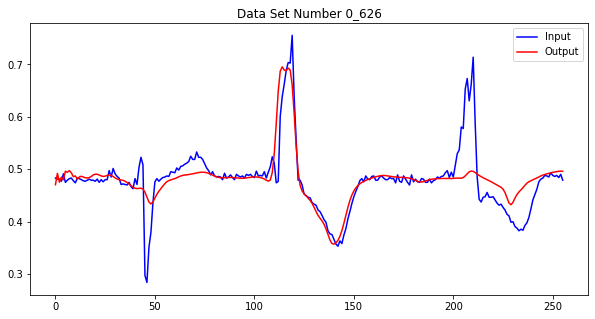

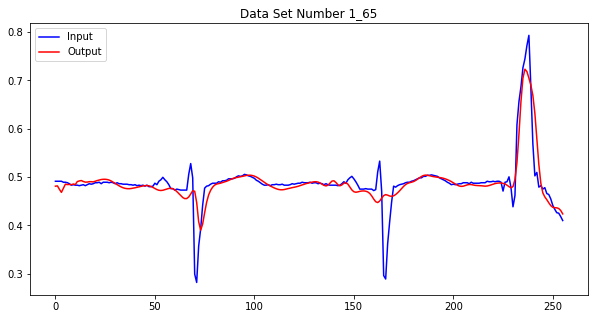

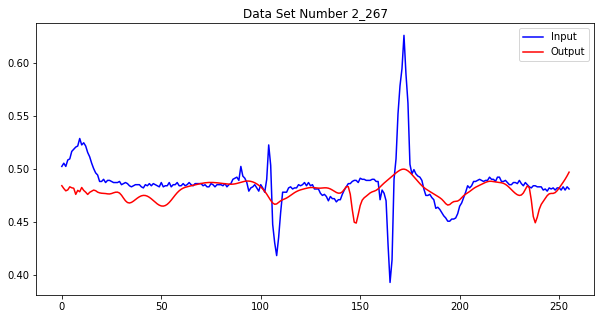

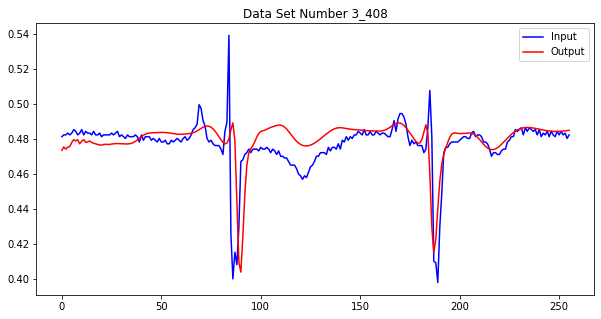

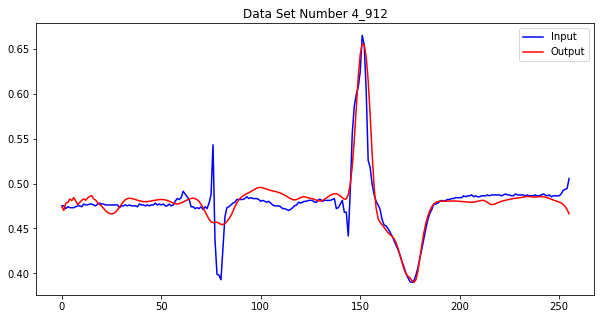

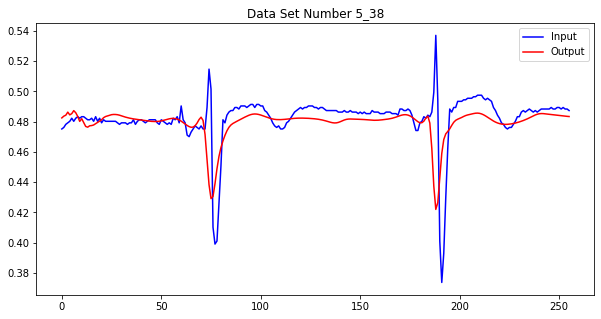

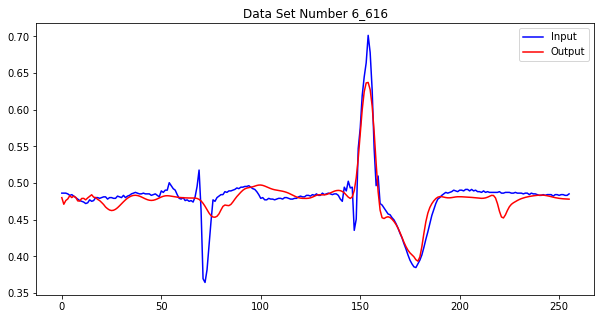

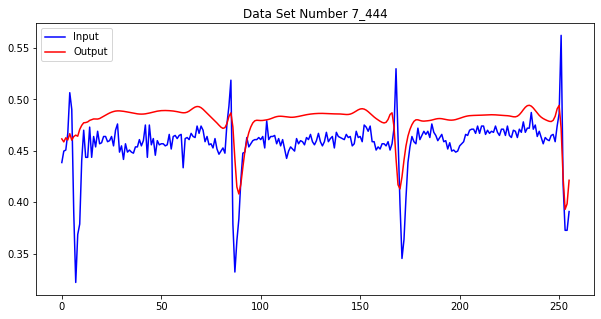

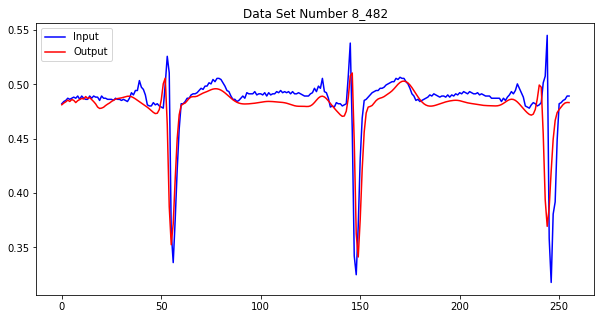

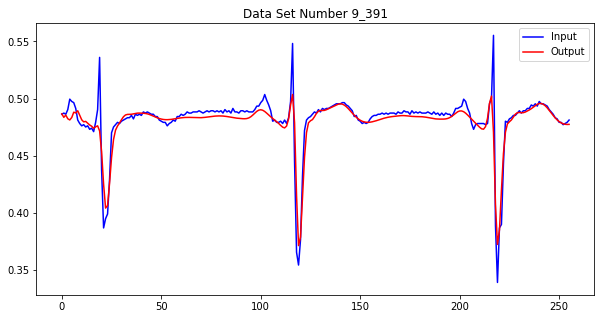

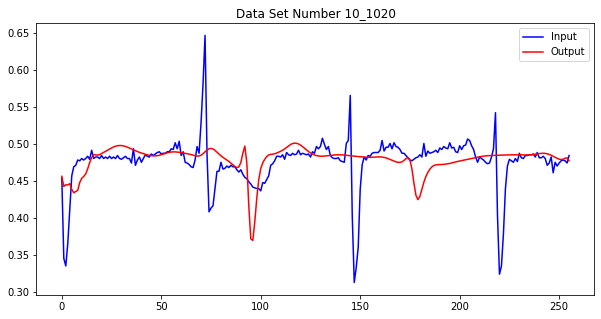

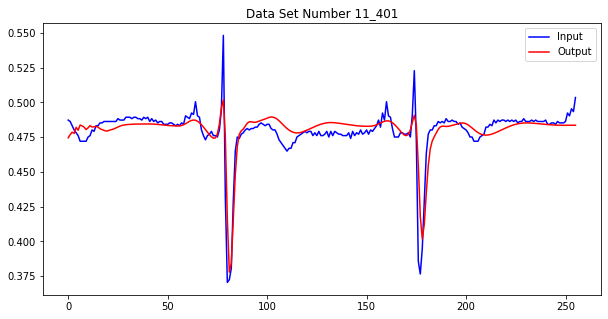

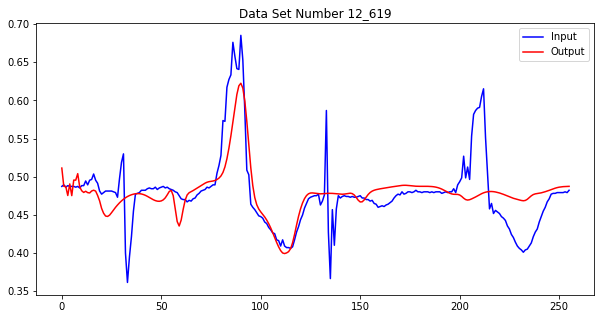

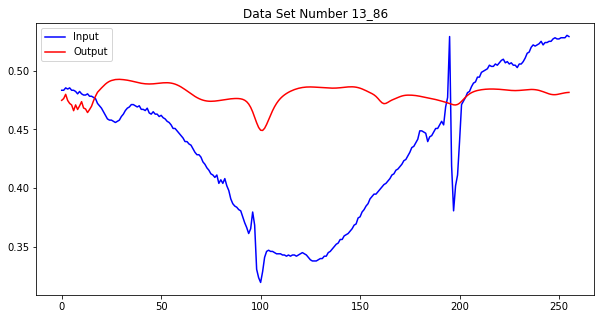

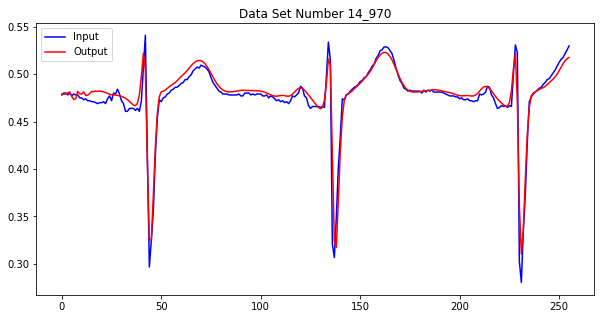

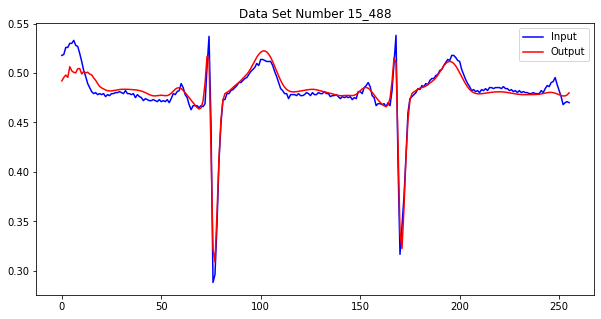

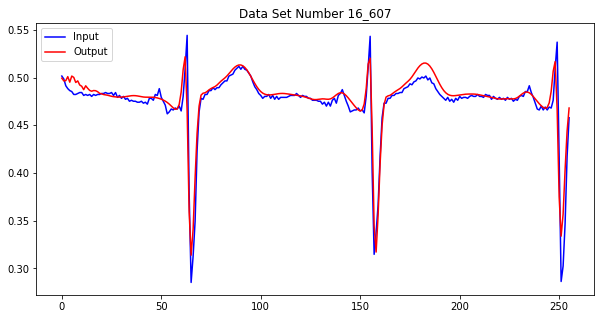

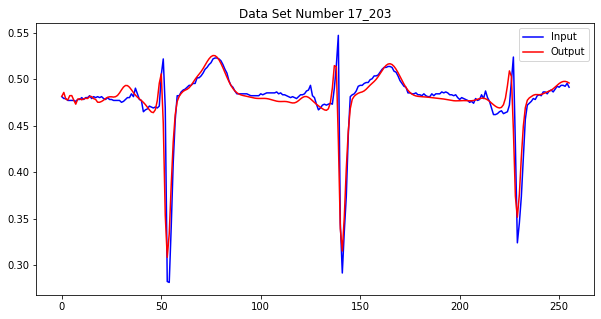

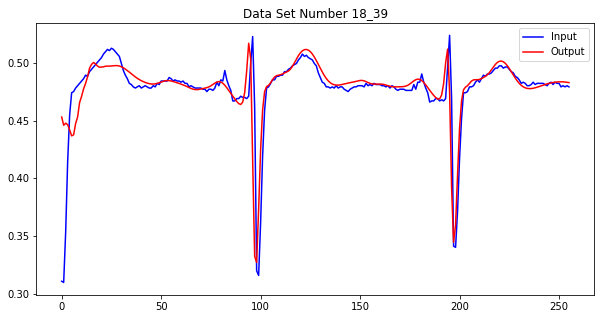

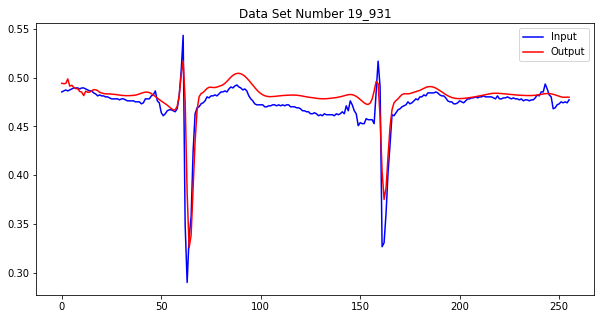

In [7]:
show_num = 20
show_idx = 0

for x in train_set:
    output, _, _ = mod(x, False)
    x_arr = x.numpy().reshape(batch_size, time_size)
    y_arr = output.numpy().reshape(batch_size, time_size)
    random_idx = np.random.permutation(x_arr.shape[0])[0]
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.plot(np.arange(time_size), x_arr[random_idx], label="Input", color="b")
    ax.plot(np.arange(time_size), y_arr[random_idx], label="Output", color="r")
    ax.legend()
    ax.set_title("Data Set Number {}_{}".format(show_idx, random_idx))
    plt.show()
    
    show_idx += 1
    
    if show_idx == show_num:
        break

# PCA 통과 후 전체 분포 확인

In [8]:
from sklearn.decomposition import PCA

In [9]:
base_mu = np.zeros((1, 30), dtype=np.float32)
base_std = np.zeros((1, 30), dtype=np.float32)

for x in train_set:
    mu, std = mod.encoder(x)
    
    mu_arr = mu.numpy()
    std_arr = std.numpy()
    
    base_mu = np.concatenate((base_mu, mu_arr), axis=0)
    base_std = np.concatenate((base_std, std_arr), axis=0)
    
base_mu = base_mu[1:]
base_std = base_std[1:]

print(base_mu.shape, base_std.shape)

(83968, 30) (83968, 30)


In [10]:
pca = PCA(n_components=2)
printcipalComponents_mu = pca.fit_transform(base_mu)
printcipalComponents_std = pca.fit_transform(base_std)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

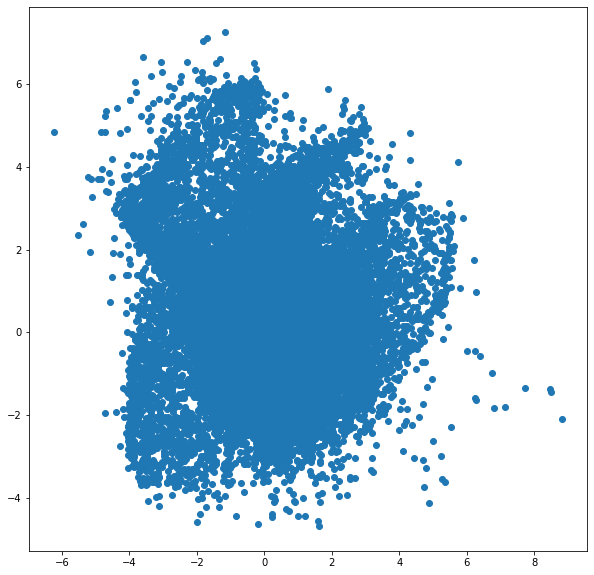

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(printcipalComponents_mu[:,0], printcipalComponents_mu[:,1])
plt.show()

# Z index 별 Histgram 관찰

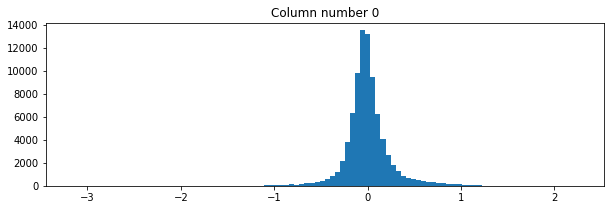

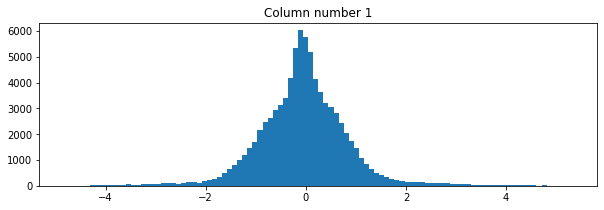

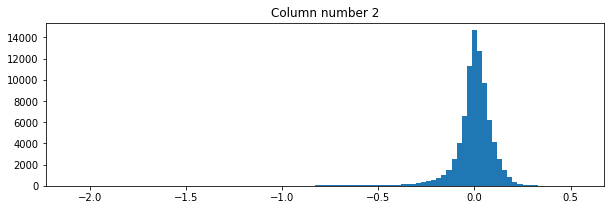

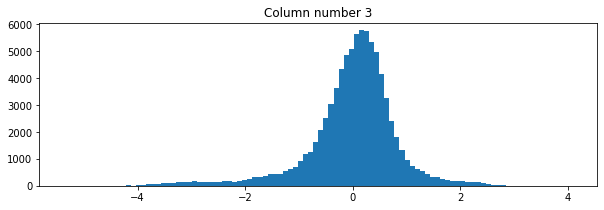

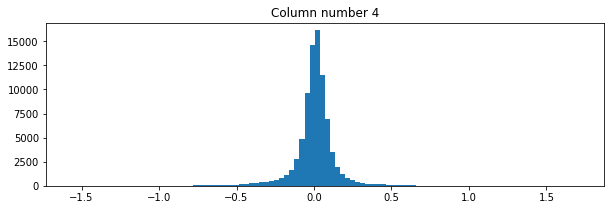

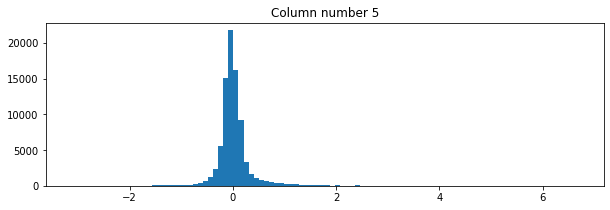

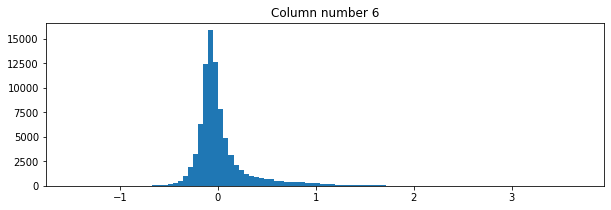

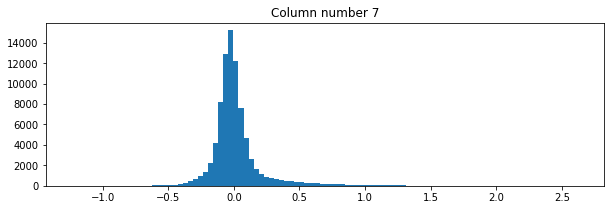

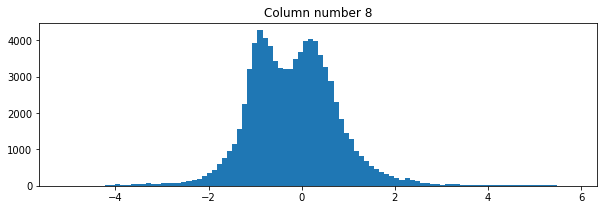

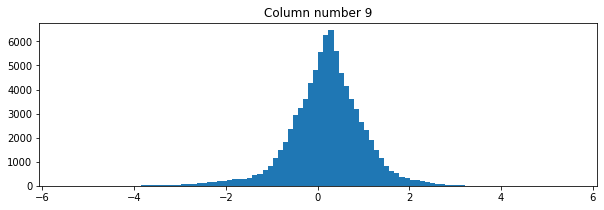

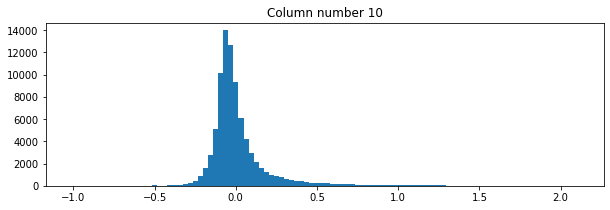

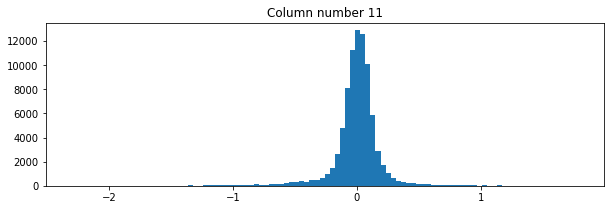

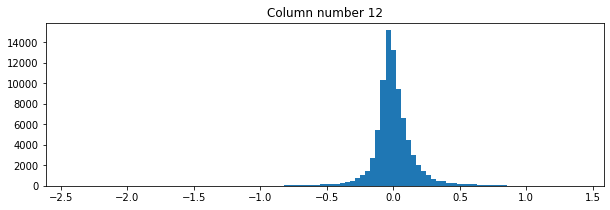

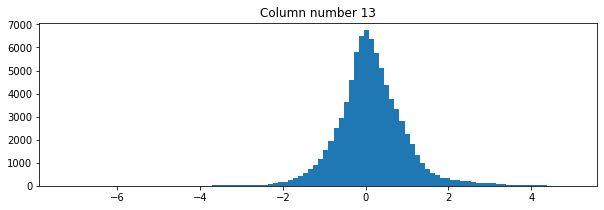

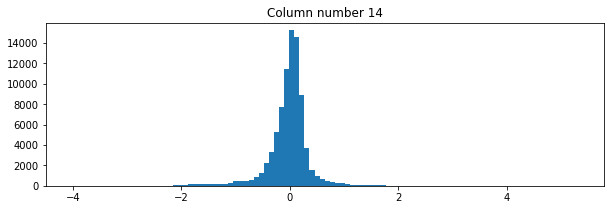

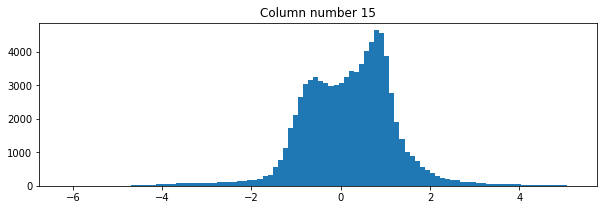

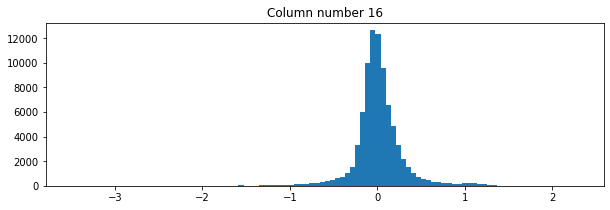

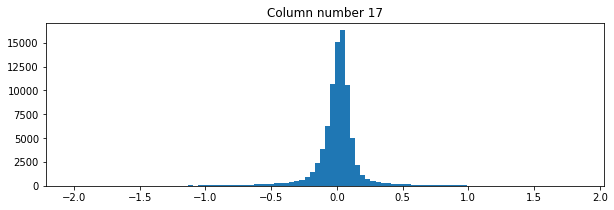

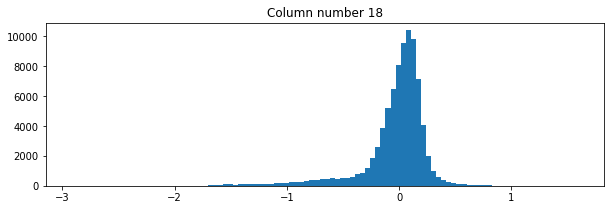

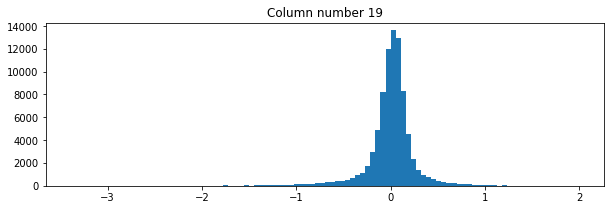

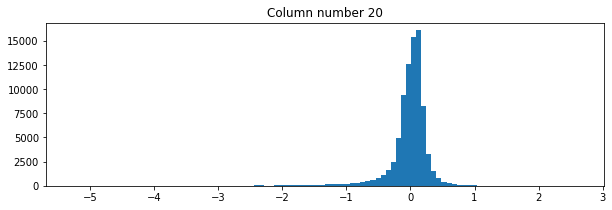

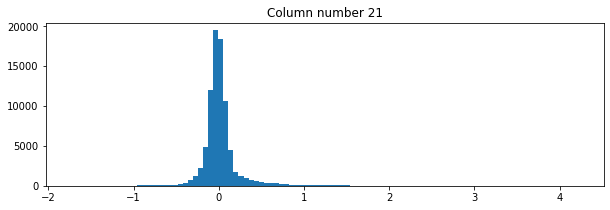

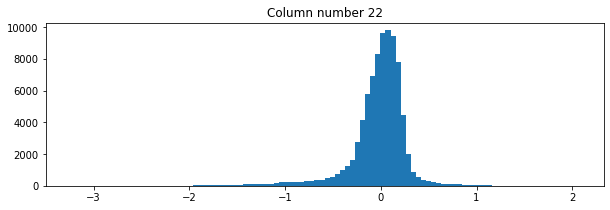

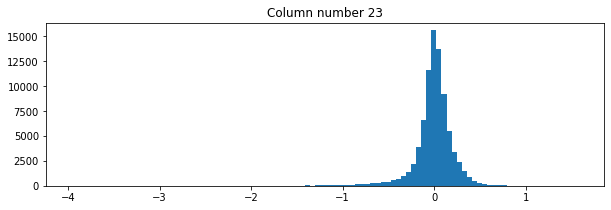

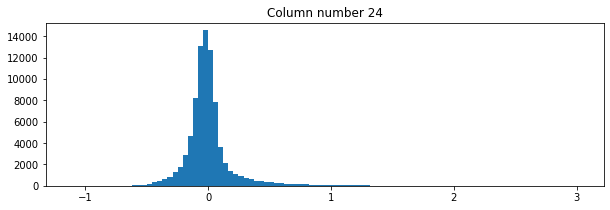

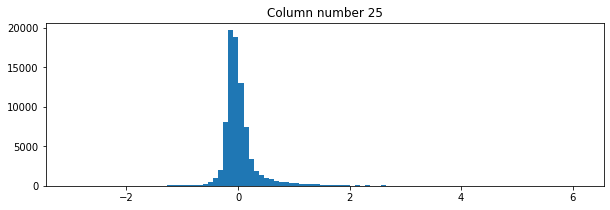

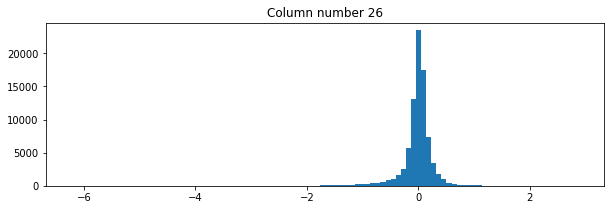

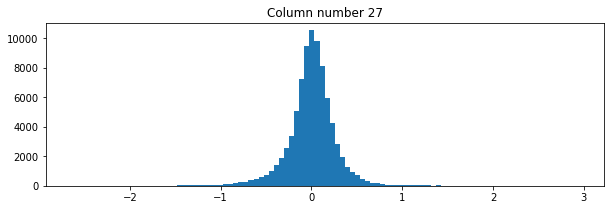

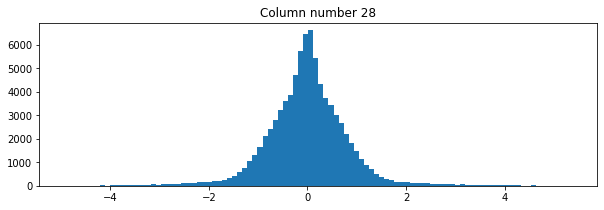

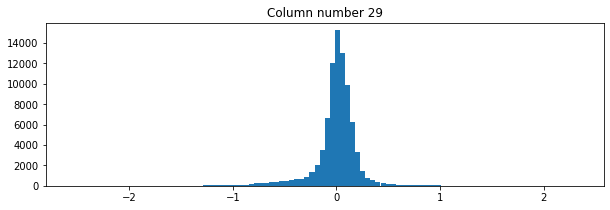

In [13]:
for idx in range(base_mu.shape[1]):
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    base_mu[:,idx]
    ax.hist(base_mu[:,idx], bins=100)
    ax.set_title("Column number {}".format(idx))
    plt.show()

# Z 변화 시키면서 생성되는 파형 관측

- 특정 Z 값만 변화 (-0.1, -0.05, 0, 0.05, 0.1) | 나머지는 0으로 고정

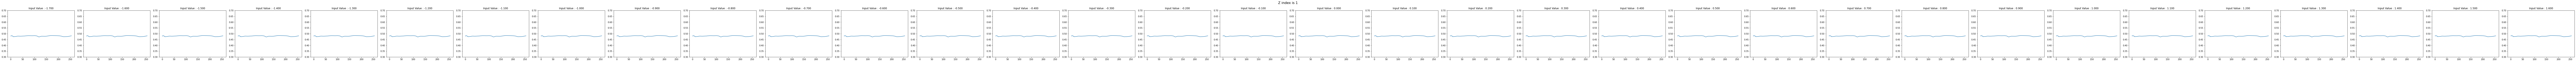

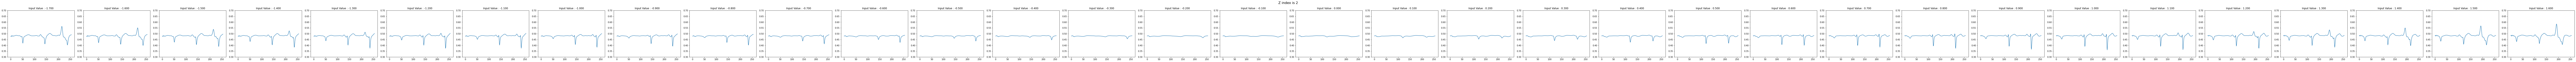

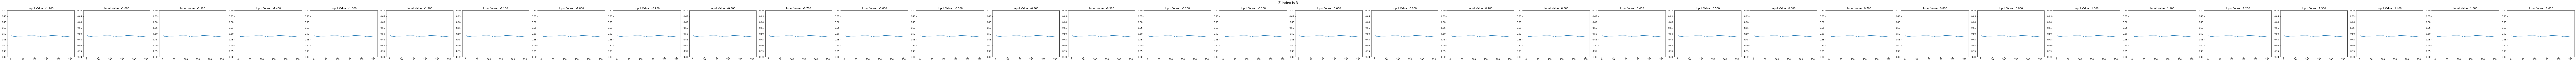

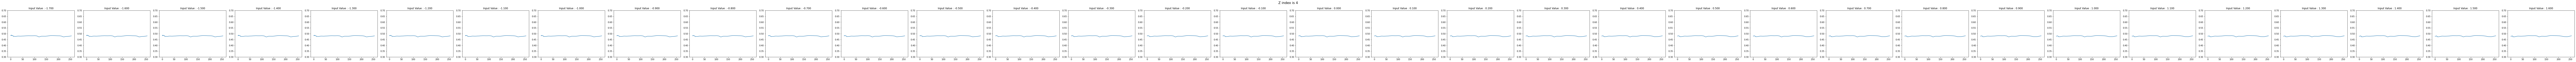

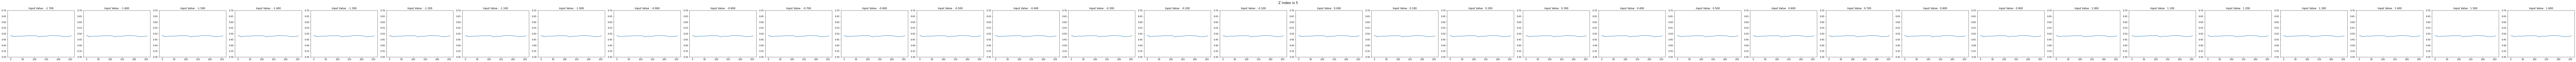

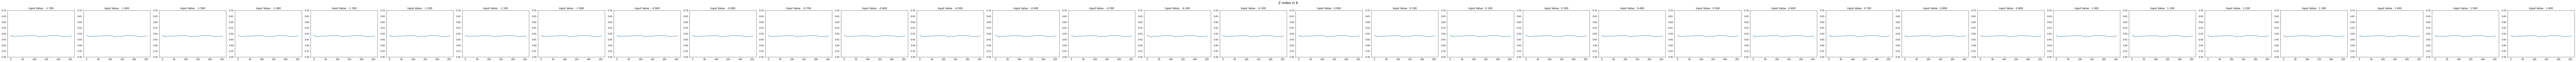

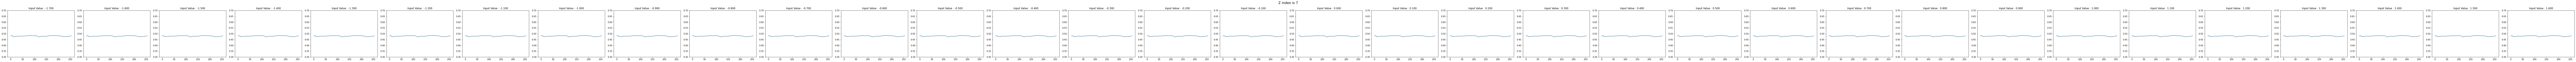

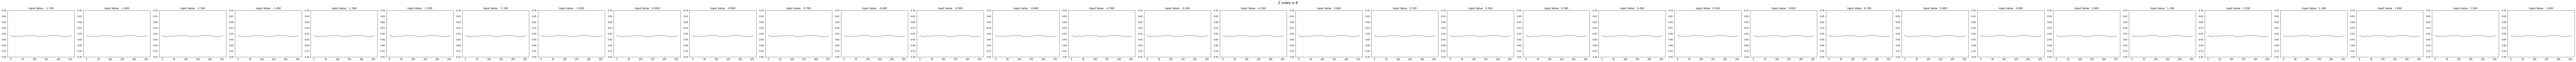

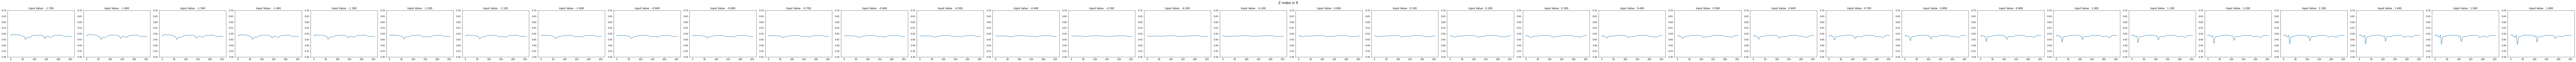

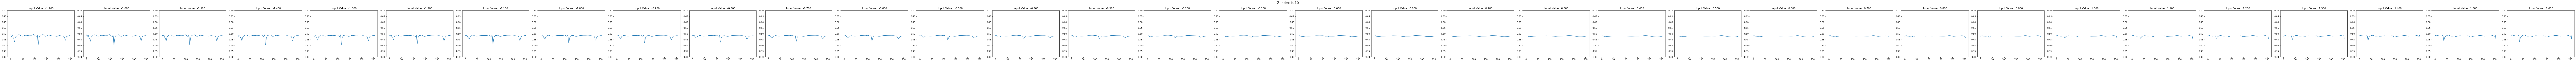

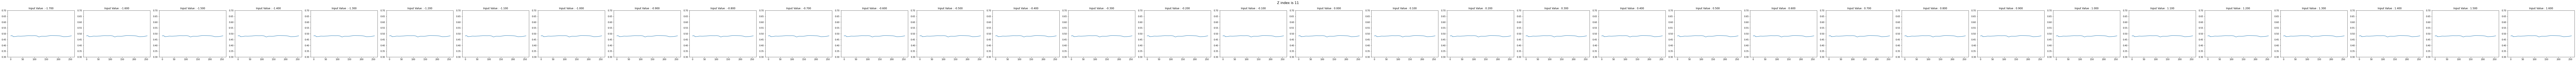

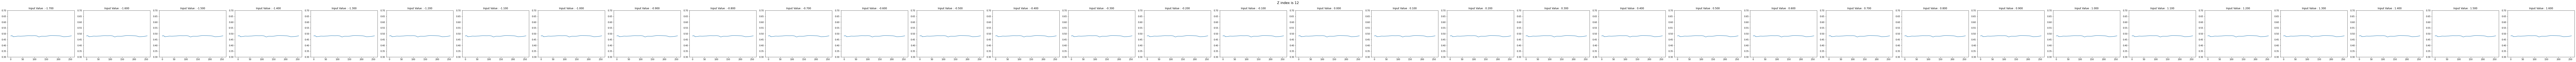

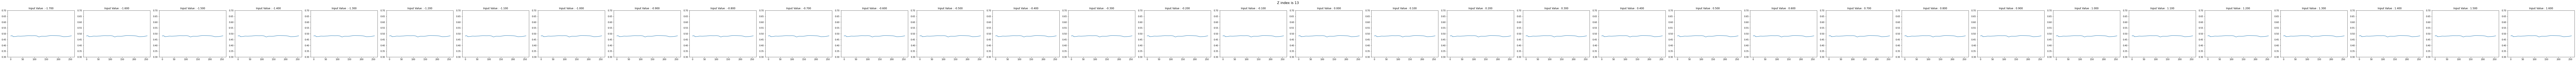

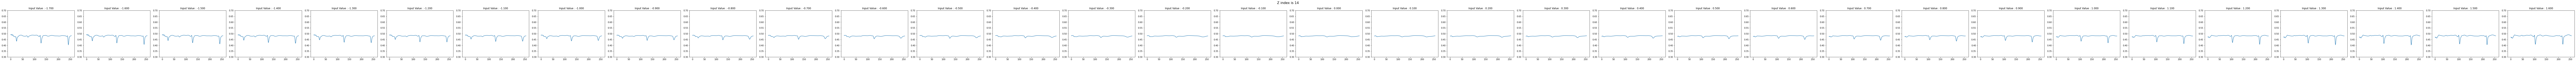

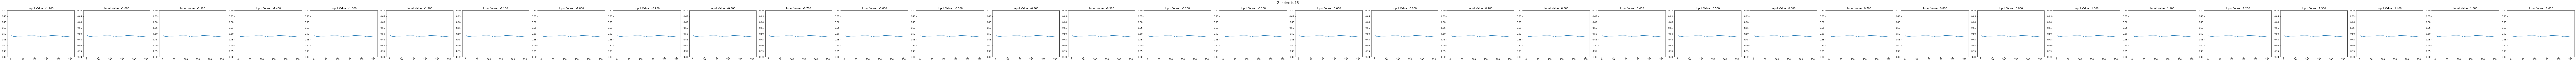

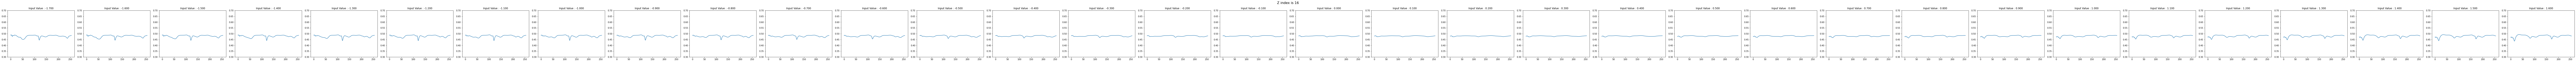

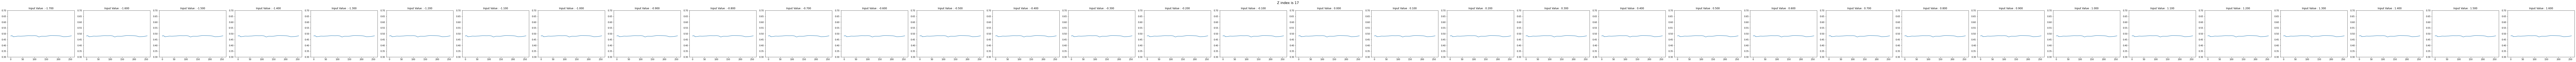

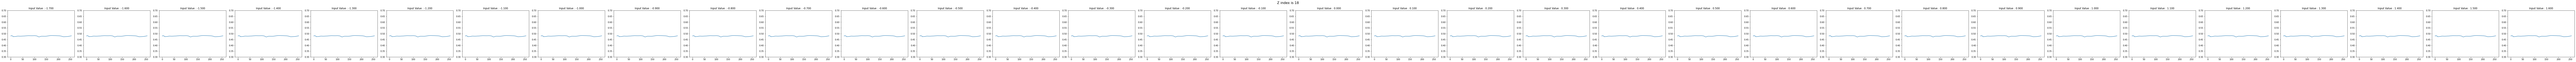

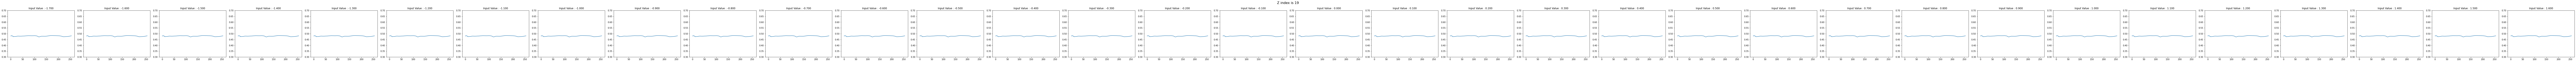

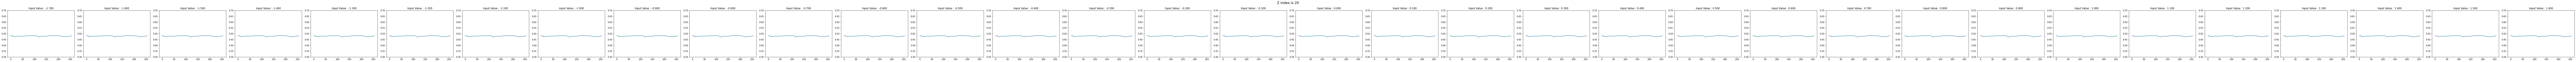

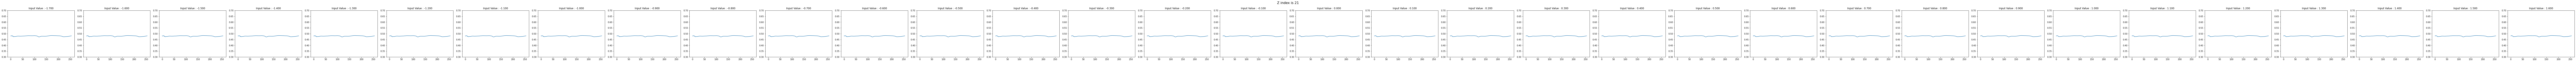

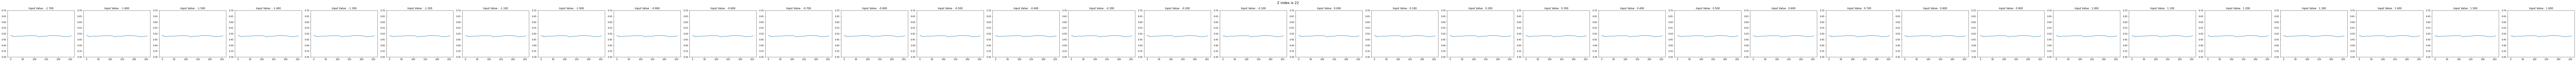

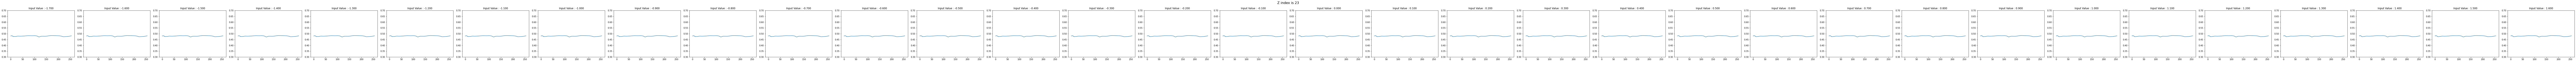

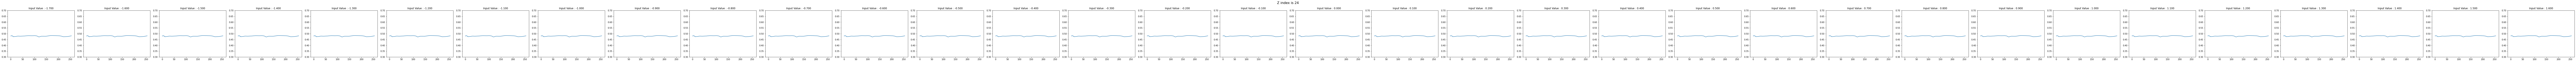

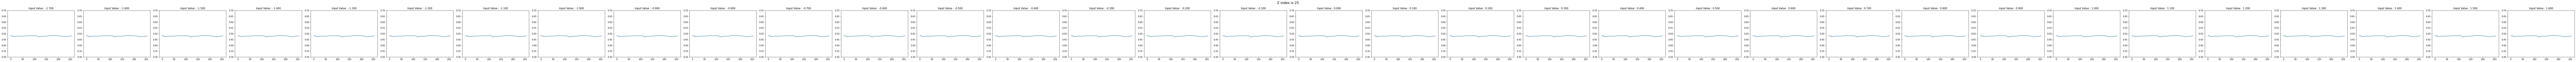

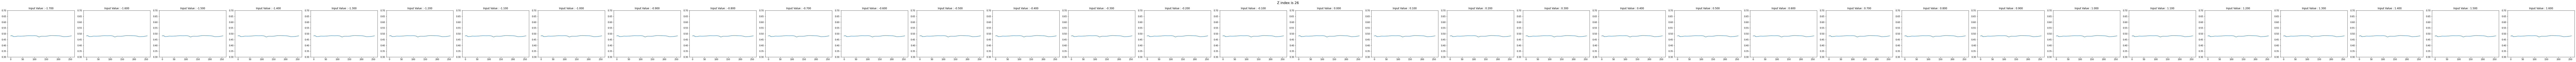

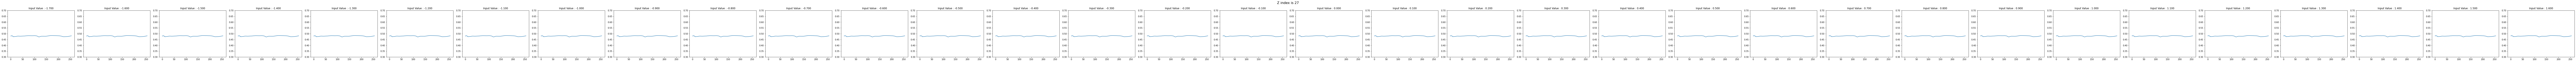

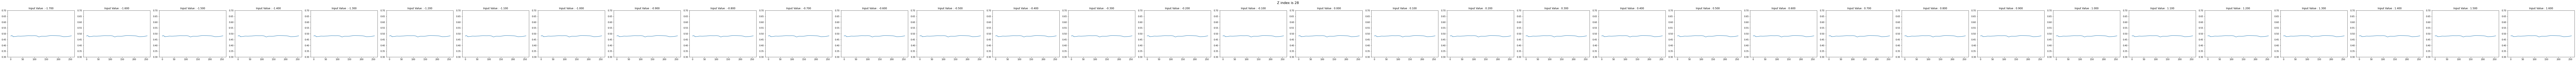

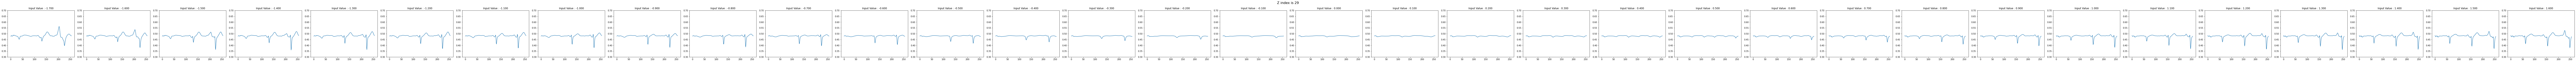

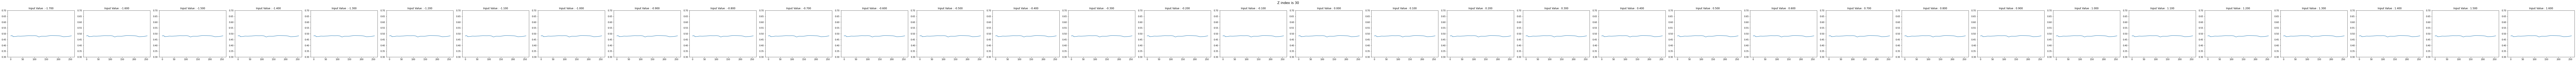

In [14]:
sample_data = np.arange(-1.7, 1.7, 0.1)

for z_idx in range(30):
    fig = plt.figure(figsize=(len(sample_data)*5,4), constrained_layout=True)
    axs = fig.subplots(1, len(sample_data))
    for idx, ax in enumerate(axs):
        for_input_mu = np.zeros((1, 30), dtype=np.float32)
        for_input_mu[0,z_idx] = sample_data[idx]
        outs = mod.decoder(for_input_mu).numpy()[0,:,0]
        ax.plot(np.arange(len(outs)), outs)
        ax.set_title("Input Value : {:.3f}".format(sample_data[idx]))
        ax.set(ylim=(0.3, 0.7))
    fig.suptitle('Z index is {}'.format(z_idx+1), fontsize=16)
    plt.show()

# PCA 사용

In [17]:
def return_pca(nums, arr):
    pca = PCA(n_components=nums)
    printcipalComponents_mu = pca.fit_transform(arr)
    return pca

def make_zsample_use_pca(pca_vactor, pca):
    return (np.array(pca_vactor).reshape(-1,1) * pca.components_).sum(axis=0)

pca_num = 6

pca = return_pca(pca_num, base_mu)

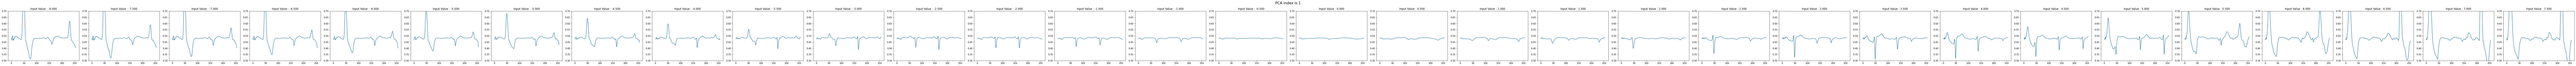

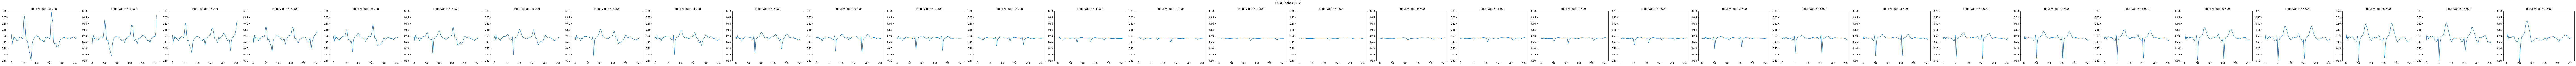

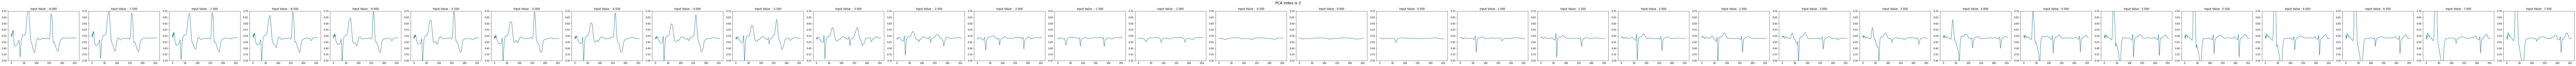

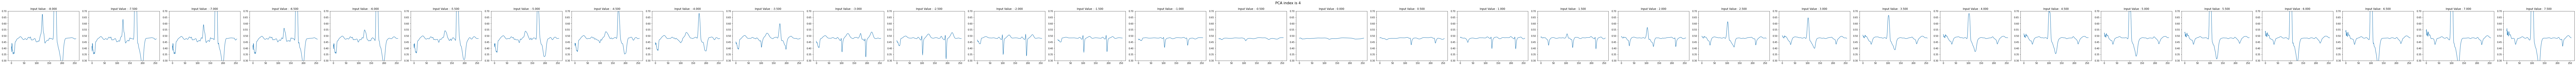

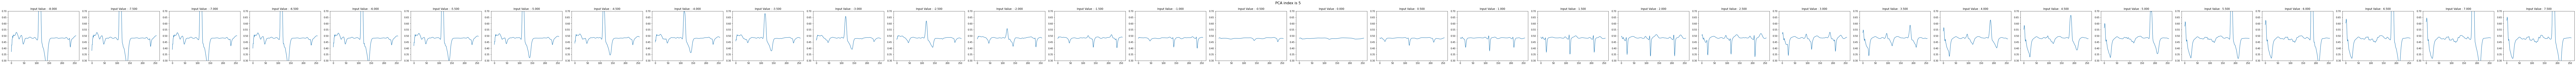

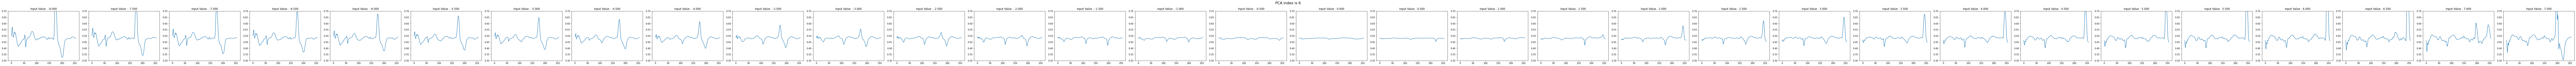

In [18]:
sample_data = np.arange(-8, 8, 0.5)

for pca_idx in range(pca_num):
    fig = plt.figure(figsize=(len(sample_data)*5,4), constrained_layout=True)
    axs = fig.subplots(1, len(sample_data))
    for idx, ax in enumerate(axs):
        pca_default = np.zeros((pca_num), dtype=np.float32)
        pca_default[pca_idx] = sample_data[idx]
        for_input_mu = make_zsample_use_pca(pca_default, pca).reshape(1,30)
        outs = mod.decoder(for_input_mu).numpy()[0,:,0]
        ax.plot(np.arange(len(outs)), outs)
        ax.set_title("Input Value : {:.3f}".format(sample_data[idx]))
        ax.set(ylim=(0.3, 0.7))
    fig.suptitle('PCA index is {}'.format(pca_idx+1), fontsize=16)
    plt.show()